<a href="https://colab.research.google.com/github/RoetGer/generalized-t-process-regression/blob/main/gen_t_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install gpflow

     |████████████████████████████████| 276kB 3.8MB/s 


In [5]:
import gpflow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

plt.rcParams["figure.figsize"] = (10, 5)

tf.__version__

'2.5.0'

In [ ]:
df = 3.
loc = tf.Variable([1., 2., 3.])
scale = [[ 0.6,  0. ,  0. ],
         [ 0.2,  0.5,  0. ],
         [ 0.1, -0.3,  0.4]]
scale = tf.linalg.LinearOperatorLowerTriangular(scale)

mvt = tfd.MultivariateStudentTLinearOperator(
    df=df,
    loc=loc,
    scale=scale)

In [ ]:
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    density = mvt.prob([0., 0., 0.])
  gradient = inner_tape.gradient(density, mvt.trainable_variables[0])

outer_tape.jacobian(gradient, mvt.trainable_variables[0])

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 6.9320464e-07, -7.5581365e-06, -9.2025548e-06],
       [-7.5581352e-06,  1.9834491e-05,  2.5120040e-05],
       [-9.2025539e-06,  2.5120042e-05,  2.7110138e-05]], dtype=float32)>

In [ ]:
mvt.trainable_variables

(<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>,)

In [ ]:
loc.shape

TensorShape([3])

### GPflow - Binary Classification

Foundation taken from [GPflow binary classification model](https://gpflow.readthedocs.io/en/master/notebooks/basics/classification.html)

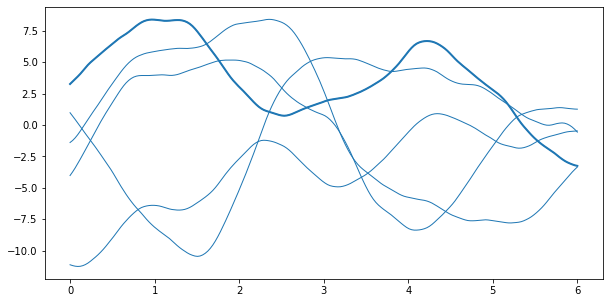

In [6]:
# build the kernel and covariance matrix
k = gpflow.kernels.Matern52(variance=20.0)
x_grid = np.linspace(0, 6, 200).reshape(-1, 1)
K = k(x_grid)

# sample from a multivariate normal
rng = np.random.RandomState(6)

L = np.linalg.cholesky(K)
f_grid = np.dot(L, rng.randn(200, 5))
plt.plot(x_grid, f_grid, "C0", linewidth=1)
_ = plt.plot(x_grid, f_grid[:, 1], "C0", linewidth=2)

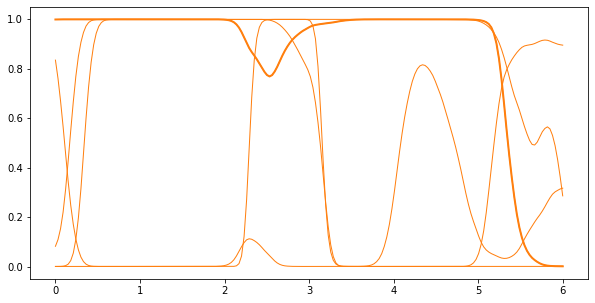

In [7]:
def invlink(f):
    # By default, standard normal CDF is used as link function, but 
    # any other function can be used as well, just set invlink argument
    # of Bernoulli()
    return gpflow.likelihoods.Bernoulli().invlink(f).numpy()


p_grid = invlink(f_grid)
plt.plot(x_grid, p_grid, "C1", linewidth=1)
_ = plt.plot(x_grid, p_grid[:, 1], "C1", linewidth=2)

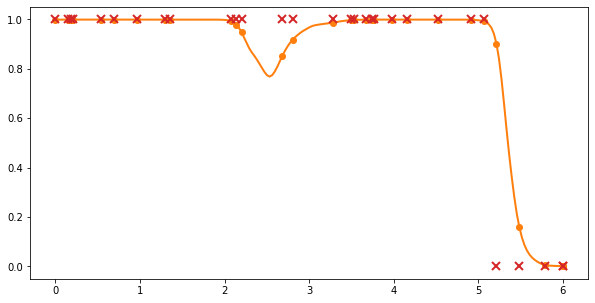

In [8]:
# Select some input locations
ind = rng.randint(0, 200, (30,))
X_gen = x_grid[ind]

# evaluate probability and get Bernoulli draws
p = p_grid[ind, 1:2]
Y_gen = rng.binomial(1, p)

# plot
plt.plot(x_grid, p_grid[:, 1], "C1", linewidth=2)
plt.plot(X_gen, p, "C1o", ms=6)
_ = plt.plot(X_gen, Y_gen, "C3x", ms=8, mew=2)

In [10]:
m = gpflow.models.VGP(
    (X_gen, Y_gen), likelihood=gpflow.likelihoods.Bernoulli(), kernel=gpflow.kernels.Matern52()
)

opt = gpflow.optimizers.Scipy()
opt.minimize(m.training_loss, variables=m.trainable_variables)

      fun: 5.921130177394291
 hess_inv: <497x497 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.78253795e-04, -1.61809166e-06,  7.97288934e-05, -2.56457370e-05,
       -3.19435981e-04, -9.77303768e-05,  3.65503836e-06, -3.55404475e-05,
        1.51691560e-06,  2.60414254e-06, -5.66910904e-07,  6.83518424e-07,
       -4.84583134e-06, -8.26329395e-07, -7.74970114e-06,  6.64908570e-06,
       -2.58952853e-07, -1.15593266e-05, -4.40631564e-07,  4.90943344e-07,
       -5.01536929e-09, -2.33588387e-09, -2.40253319e-06,  1.37008530e-07,
       -3.01552016e-07, -3.93965023e-07, -2.99033797e-08, -3.87416728e-08,
       -3.92586551e-08,  2.05379648e-08,  2.92843059e-06, -8.10135283e-08,
       -8.38028936e-08,  6.45942925e-16,  4.92766267e-11,  3.41825071e-15,
        5.14826996e-14, -3.38859041e-13,  1.52259895e-13,  9.40644512e-09,
       -2.80741643e-09,  6.83393397e-09,  5.31380897e-16, -2.47080565e-11,
        5.19857243e-13,  4.81490492e-09, -2.39469898e-08, -7.80634456e-10,
